## Model

In [1]:
import pandas as pd
df = pd.read_csv("data/forecasts.csv")
df.head()

,Quarter,Estimate Type,Predicted Value,Real Value,Company,Analyst,Bank,Market Cap,Sector,Start Date,Horizon,Revision Time
0,Q1 2013,Stock Price,2.651234e+01,3.127849e+01,Company5,Analyst513,JP Morgan,Mid Cap,Technology,2013-02-19,Q1,Initial
1,Q1 2013,Stock Price,2.928395e+01,3.127849e+01,Company5,Analyst513,Goldman Sachs,Mid Cap,Technology,2013-02-19,Q2,Initial
2,Q1 2013,EBITDA,1.551400e+09,1.226174e+09,Company5,Analyst513,Citi,Mid Cap,Technology,2013-02-19,Q0,Initial
3,Q1 2013,EBITDA,1.174947e+09,1.226174e+09,Company5,Analyst513,Morgan Stanley,Mid Cap,Technology,2013-02-19,Q1,Initial
4,Q1 2013,EBITDA,1.452862e+09,1.226174e+09,Company5,Analyst513,Citi,Mid Cap,Technology,2013-02-19,Q2,Initial


In [2]:
# Build the quarter_ends_map right here
start_date   = pd.Timestamp("2013-01-01")
end_date     = pd.Timestamp("2023-01-01")
trading_days = pd.date_range(start_date, end_date, freq='B')
quarter_ends = trading_days.to_series().groupby(trading_days.to_period("Q")).last().values
quarter_ends = pd.to_datetime(quarter_ends)

quarter_ends_map = {
    f"Q{d.quarter} {d.year}": d
    for d in quarter_ends
}

## Approach 1: Ridge‑Based Weighted Consensus

We have a collection of analyst forecasts indexed by $i = 1,\dots,N$.  For each forecast $i$, we observe:

- **Predicted value** $p_i$  
- **Realized value** $y_i$  
- A feature vector $\mathbf{x}_i\in\mathbb{R}^d$ encoding:  
  - One‑hot indicators for Analyst$_i$, Sector$_i$, MarketCap$_i$, Metric$_i$, Horizon$_i$  
  - A numeric “months‑before” variable $\mathrm{RevMonths}_i$

Define the **percent error** target
$$
e_i \;=\; \frac{\lvert p_i - y_i\rvert}{\lvert y_i\rvert + \varepsilon}
\quad,\quad
\varepsilon = 10^{-6}.
$$

---

### 1. Fitting Ridge Regression

Stack all feature vectors into a design matrix
$$
X = 
\begin{bmatrix}
\mathbf{x}_1^\top \\[3pt]
\mathbf{x}_2^\top \\[1pt]
\vdots \\[1pt]
\mathbf{x}_N^\top
\end{bmatrix}
\in\mathbb{R}^{N\times d},
\quad
\mathbf{e} = (e_i)_{i=1}^N \in\mathbb{R}^N.
$$

Solve the **Ridge** regression problem
$$
\hat{\boldsymbol\beta}
=
\arg\min_{\boldsymbol\beta\in\mathbb{R}^d}
\left\{
\sum_{i=1}^N \bigl(e_i - \mathbf{x}_i^\top\boldsymbol\beta\bigr)^2
\;+\;\alpha\,\|\boldsymbol\beta\|_2^2
\right\},
$$
where $\alpha$ is chosen by cross‑validation.  The fitted model predicts each error as
$$
\widehat e_i = \mathbf{x}_i^\top\hat{\boldsymbol\beta}.
$$

---

### 2. Constructing the Weighted Consensus

For any **forecasting context** $c$ (defined by Quarter, Company, Metric, Horizon), let
$$
I_c = \{\,i : \text{forecast }i\text{ belongs to }c\}.
$$
Collect $\{p_i : i\in I_c\}$ and their predicted errors $\{\widehat e_i\}$.

1. **Simple consensus**  
   $$
     \bar p_c 
     = \frac{1}{\lvert I_c\rvert}
       \sum_{i\in I_c} p_i.
   $$

2. **Model‑weighted consensus**  
   Compute raw weights
   $$
     w_i = \frac{1}{\widehat e_i},
     \quad i\in I_c,
   $$
   normalize
   $$
     \tilde w_i 
     = \frac{w_i}{\sum_{j\in I_c} w_j},
   $$
   then
   $$
     \hat p_c 
     = \sum_{i\in I_c} \tilde w_i\,p_i
     = \frac{\sum_{i\in I_c} \tfrac{1}{\widehat e_i}\,p_i}
            {\sum_{i\in I_c} \tfrac{1}{\widehat e_i}}.
   $$

---

### 3. Evaluation Metric

For each context $c$, with true value $y_c$, compute:

- **Error of simple consensus**  
  $$
    \mathrm{Err}_{\mathrm{simple},c}
    = \frac{\lvert \bar p_c - y_c\rvert}{\lvert y_c\rvert + \varepsilon}.
  $$

- **Error of model consensus**  
  $$
    \mathrm{Err}_{\mathrm{model},c}
    = \frac{\lvert \hat p_c - y_c\rvert}{\lvert y_c\rvert + \varepsilon}.
  $$

Then average over all contexts $\mathcal{C}$:
$$
\mathrm{AvgErr}_{\mathrm{simple}}
=\frac{1}{\lvert\mathcal{C}\rvert}\sum_{c\in\mathcal{C}}\mathrm{Err}_{\mathrm{simple},c},
\quad
\mathrm{AvgErr}_{\mathrm{model}}
=\frac{1}{\lvert\mathcal{C}\rvert}\sum_{c\in\mathcal{C}}\mathrm{Err}_{\mathrm{model},c}.
$$

Typically one finds  
$\mathrm{AvgErr}_{\mathrm{model}} < \mathrm{AvgErr}_{\mathrm{simple}}$,
showing that the Ridge‑derived weighting outperforms the naive average.

In [3]:
from support_functions import assign_rev_bucket

# Keep rows where we actually know the Real Value
df_reg = df[df["Real Value"].notnull()].copy()

# Bucket into Rev 3m/2m/1m and map to numeric months
df_reg = assign_rev_bucket(df_reg, quarter_ends_map)
df_reg["RevMonths"] = df_reg["RevBucket"].map({"Rev 3m": 3, "Rev 2m": 2, "Rev 1m": 1})

# Compute percent‐error target
EPS = 1e-6
df_reg["PctErr"] = (
    (df_reg["Predicted Value"] - df_reg["Real Value"]).abs() 
    / (df_reg["Real Value"].abs() + EPS)
)

print("Training rows:", len(df_reg))
print(df_reg[["Company","Analyst","Estimate Type","Horizon","RevBucket","PctErr"]].head())

Training rows: 10296889
        Company    Analyst Estimate Type Horizon RevBucket    PctErr
2946  Company18  Analyst27   Stock Price      Q0    Rev 2m  0.037130
2947  Company18  Analyst27   Stock Price      Q1    Rev 2m  0.056264
2948  Company18  Analyst27   Stock Price      Q2    Rev 2m  0.028828
2949  Company18  Analyst27        EBITDA      Q0    Rev 2m  0.033488
2950  Company18  Analyst27        EBITDA      Q1    Rev 2m  0.023862


In [4]:
from scipy import sparse
from sklearn.preprocessing import OneHotEncoder

# categorical columns
cat_cols = ["Analyst", "Sector", "Market Cap", "Estimate Type", "Horizon"]

# Set up a sparse one-hot encoder
ohe = OneHotEncoder(
    categories='auto',
    drop=None,
    sparse_output=True,         # produce a scipy.sparse matrix directly
    handle_unknown='ignore'
)

# Fit+transform your cats
X_cat_sp = ohe.fit_transform(df_reg[cat_cols])
print("Encoded cats → sparse matrix:", X_cat_sp.shape)

# Your numeric feature as sparse too
X_num_sp = sparse.csr_matrix(df_reg[["RevMonths"]].values)
print("Numeric feature → sparse matrix:", X_num_sp.shape)

# Stack them horizontally
X_sp = sparse.hstack([X_cat_sp, X_num_sp], format='csr')
print("Final sparse design matrix X_sp:", X_sp.shape)

# target
y = df_reg["PctErr"].to_numpy()
print("y shape:", y.shape)

Encoded cats → sparse matrix: (10296889, 718)
Numeric feature → sparse matrix: (10296889, 1)
Final sparse design matrix X_sp: (10296889, 719)
y shape: (10296889,)


In [5]:
import numpy as np
alphas = np.logspace(-2, -1, num=50)
print(alphas)

[0.01       0.01048113 0.01098541 0.01151395 0.01206793 0.01264855
 0.01325711 0.01389495 0.01456348 0.01526418 0.01599859 0.01676833
 0.01757511 0.0184207  0.01930698 0.0202359  0.02120951 0.02222996
 0.02329952 0.02442053 0.02559548 0.02682696 0.02811769 0.02947052
 0.03088844 0.03237458 0.03393222 0.0355648  0.03727594 0.0390694
 0.04094915 0.04291934 0.04498433 0.04714866 0.04941713 0.05179475
 0.05428675 0.05689866 0.05963623 0.06250552 0.06551286 0.06866488
 0.07196857 0.0754312  0.07906043 0.08286428 0.08685114 0.09102982
 0.09540955 0.1       ]


In [6]:
from sklearn.linear_model import RidgeCV

# set up RidgeCV
ridge = RidgeCV(
    alphas=alphas,
    cv=5,
    scoring="neg_mean_absolute_error",
    fit_intercept=True
)

print("Fitting RidgeCV on", X_sp.shape, "...")
ridge.fit(X_sp, y)
print("Best α:", ridge.alpha_)

Fitting RidgeCV on (10296889, 719) ...
Best α: 0.03393221771895328


In [9]:
# extract the coefficients and isolate the “Analyst” effects:
# pull out the learned coef vector
coef = pd.Series(ridge.coef_, index=ohe.get_feature_names_out().tolist() + ["RevMonths"])

# pick just the analyst columns
analyst_coefs = (
    coef
      .loc[coef.index.str.startswith("Analyst_")]
      .rename(lambda s: s.replace("Analyst_", ""))
      .sort_values()
)

print("\nTop 10 analysts by learned (lowest) error‐contribution:")
print(analyst_coefs.head(10))


Top 10 analysts by learned (lowest) error‐contribution:
Analyst631   -0.073288
Analyst488   -0.055912
Analyst332   -0.048565
Analyst636   -0.048271
Analyst494   -0.046618
Analyst5     -0.046254
Analyst660   -0.045542
Analyst612   -0.043758
Analyst492   -0.039375
Analyst22    -0.038227
dtype: float64


In [8]:
# Evaluate consensus across all horizons (Q0, Q1, Q2)

from scipy import sparse

# 1) Prepare evaluation DataFrame (no horizon filter)
df_eval = df_reg.copy()
print("Evaluating on", len(df_eval), "forecasts across all horizons")

# 2) Rebuild design matrix for df_eval
X_eval_cat = ohe.transform(df_eval[cat_cols])                                # sparse (n_eval, n_cat)
X_eval_num = sparse.csr_matrix(df_eval[["RevMonths"]].values)                # sparse (n_eval, 1)
X_eval     = sparse.hstack([X_eval_cat, X_eval_num], format="csr")          # sparse (n_eval, n_features)

# 3) Predict each row’s %‐error
df_eval["PredPctErr"] = ridge.predict(X_eval).clip(min=1e-3)

# 4) Compute simple‐mean vs. model‐weighted consensus per (Q, Company, Metric, Horizon)
results = []
for (q, comp, met, hor), sub in df_eval.groupby(
    ["Quarter","Company","Estimate Type","Horizon"],
    sort=False
):
    true_val = sub["Real Value"].iloc[0]
    # a) equal‐weight consensus
    simple = sub["Predicted Value"].mean()
    # b) model‐weight: weight = 1 / PredPctErr
    w = 1.0 / sub["PredPctErr"]
    w /= w.sum()
    model_consensus = (sub["Predicted Value"] * w).sum()

    results.append({
        "Quarter":    q,
        "Company":    comp,
        "Metric":     met,
        "Horizon":    hor,
        "True":       true_val,
        "Simple":     simple,
        "Model":      model_consensus,
        "Err_Simple": abs(simple       - true_val) / (abs(true_val) + EPS),
        "Err_Model":  abs(model_consensus - true_val) / (abs(true_val) + EPS),
    })

eval_df = pd.DataFrame(results)

# 5) Overall average absolute %‐error
print("Average absolute % error overall:")
print(eval_df[["Err_Simple","Err_Model"]].mean(), "\n")

# 6) Breakdown by horizon
print("Average absolute % error by Horizon:")
print(eval_df.groupby("Horizon")[["Err_Simple","Err_Model"]].mean())

Evaluating on 10296889 forecasts across all horizons
Average absolute % error overall:
Err_Simple    0.246501
Err_Model     0.246446
dtype: float64 

Average absolute % error by Horizon:
         Err_Simple  Err_Model
Horizon                       
Q0         0.027573   0.027572
Q1         0.255936   0.255921
Q2         0.468190   0.468039


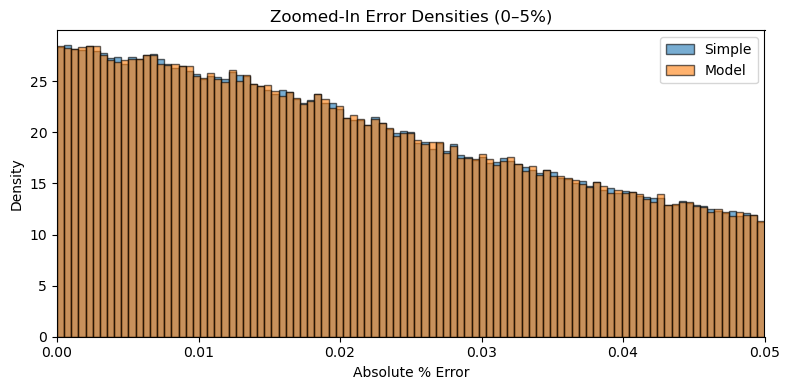

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Zoomed‐in density histograms from 0–5%
plt.figure(figsize=(8,4))
bins = np.linspace(0, 0.05, 100)

plt.hist(eval_df["Err_Simple"],
         bins=bins,
         density=True,
         alpha=0.6,
         label="Simple",
         edgecolor="black")
plt.hist(eval_df["Err_Model"],
         bins=bins,
         density=True,
         alpha=0.6,
         label="Model",
         edgecolor="black")

plt.xlim(0, 0.05)
plt.xlabel("Absolute % Error")
plt.ylabel("Density")
plt.title("Zoomed‐In Error Densities (0–5%)")
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
from scipy.stats import wilcoxon

stat, pval = wilcoxon(eval_df["Err_Simple"], eval_df["Err_Model"])
print(f"Wilcoxon signed‑rank test: stat={stat:.2f}, p‑value={pval:.3g}")

Wilcoxon signed‑rank test: stat=38641750793.00, p‑value=0


- Across all horizons, the model is *very slightly* better—improvements are on the order of **0.001 – 0.015 bp**.
- Simple vs. Model histograms almost overlap, showing nearly identical performance for the vast majority of contexts.
- **p-value** << 0.05 tells us the difference is **statistically significant** at any conventional level. But statistical significance here arises from our huge sample size;
where even a tiny effect becomes "significant" (**not practically significant!**).
- We may need richer features (e.g: analyst-specific time-decay, company life-cycle, macro regime, interaction terms) or
- More sophisticated models.